In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
#from wordcloud import STOPWORDS

In [2]:
movies = pd.read_csv('movies_metadata.csv', low_memory=False)
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [3]:
movies = movies[['title', 'overview', 'imdb_id', 'popularity']]
movies = movies.sort_values(by='Popularity', ascending=False)
print(movies.head(3))

              title                                           overview  \
0         Toy Story  Led by Woody, Andy's toys live happily in his ...   
1           Jumanji  When siblings Judy and Peter discover an encha...   
2  Grumpier Old Men  A family wedding reignites the ancient feud be...   

     imdb_id popularity  
0  tt0114709  21.946943  
1  tt0113497  17.015539  
2  tt0113228    11.7129  


In [4]:
print(movies.isnull().sum())
print(movies.shape)

title           6
overview      954
imdb_id        17
popularity      5
dtype: int64
(45466, 4)


In [5]:
# movies.dropna(inplace=True)
# print(movies.isnull().sum())
# print(movies.shape)
# print(movies[movies['title'] == 'A Farewell to Arms'].head(3))

In [6]:
# duplicates_series = movies.duplicated(subset=['title', 'imdb_id'], keep=False)
# duplicates = movies[duplicates_series].sort_values(by='title').copy().reset_index(drop=True)
# print(duplicates.head(3))
# print(duplicates.shape)

In [7]:
# movies.drop_duplicates(subset=['title', 'imdb_id'], keep='first', inplace=True)
# print(movies[movies['title'] == 'A Farewell to Arms'].head(3))

30
Empty DataFrame
Columns: [title, overview, imdb_id, popularity]
Index: []


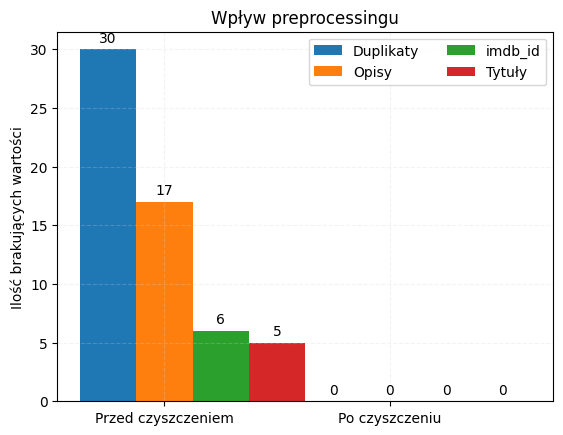

In [8]:

missing_values = movies.isna().sum().sort_values()
movies.dropna(inplace=True)
missing_values_cleaned = movies.isna().sum().sort_values()



row_count = movies.shape[0]
movies.drop_duplicates(subset=['title', 'imdb_id'], keep='first', inplace=True)
row_count_no_duplicates = movies.shape[0]

duplicates_sum = row_count - row_count_no_duplicates
print(duplicates_sum)

print(movies[movies.duplicated(subset=['title', 'imdb_id'], keep=False)])

data = {
    'Duplikaty': (duplicates_sum, 0),
    'Opisy': (missing_values[2], missing_values_cleaned[2]),
    'imdb_id': (missing_values[1], missing_values_cleaned[1]),   
    'Tytuły': (missing_values[0], missing_values_cleaned[0]),
}

plt.style.use('default')
fig, ax = plt.subplots()
#fig.set_figwidth(20)


labels_bar = ('Przed czyszczeniem', 'Po czyszczeniu')
x = np.arange(len(labels_bar))
width = 0.25
multiplier = 0

for col, missing_sum in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, missing_sum, width, label=col)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Wpływ preprocessingu')
ax.set_ylabel('Ilość brakujących wartości')
ax.set_xticks(x + width, labels_bar)
ax.legend(loc='upper right', ncols=2)

plt.grid(True, linestyle='--', color='lightgrey', alpha=.25)
fig.savefig('preprocessing.jpg')

plt.show()








In [9]:
# movies = movies.iloc[:10000, :]
# print(movies.shape)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(stop_words='english', max_df = 0.7)
tfidf_matrix = tfidf_vect.fit_transform(movies['overview'].values)

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

movies_cosine = pd.DataFrame(cosine_sim_matrix,
                            index=movies['title'].values,
                            columns=movies['title'].values)

print(movies_cosine.iloc[:3, :3])

                  Toy Story   Jumanji  Grumpier Old Men
Toy Story          1.000000  0.015016          0.000000
Jumanji            0.015016  1.000000          0.046822
Grumpier Old Men   0.000000  0.046822          1.000000


In [12]:
# from sklearn.metrics.pairwise import linear_kernel

# linear_kernel_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)

# movies_cosine = pd.DataFrame(linear_kernel_matrix,
#                             index=movies['title'].values,
#                             columns=movies['title'].values)

# print(movies_cosine.iloc[:3, :3])

In [166]:
def find_similar_to(title=''):
    try:
        similiarities = movies_cosine.loc[title]
    except KeyError:
        print(f'Brak filmu "{title}" w bazie.')
        return

    if isinstance(similiarities, pd.core.frame.DataFrame):
        similiarities = similiarities.iloc[0]

    top_similiarities = similiarities.sort_values(ascending=False)
    return dict(top_similiarities[1:11].items())

In [215]:
def create_chart_for_matches(matches, title, savetofile=False):
    if matches is None:
        return
    
    plt.style.use('ggplot')
    fig, ax = plt.subplots()

    movies = tuple(matches.keys())
    similarity = tuple(matches.values())
    y_pos = np.arange(len(movies))

    bars = ax.barh(y_pos,
                   similarity,
                   color=plt.cm.rainbow(np.linspace(0, 1, len(movies))))

    for movie, sim in zip(movies, similarity):
        plt.text(sim + 0.004,
                 movies.index(movie),
                 f'{sim:.2f}',
                 ha='left',
                 va='center')


    ax.set_title('Najlepsze dopasowania dla filmu {}'.format(title),
                 fontsize=18,
                 loc='left')
    ax.invert_yaxis()
    ax.set_yticks(y_pos, labels=movies)
    ax.set_xlabel('Podobieństwo opisów')

    if savetofile:
        fig.savefig('{}_matches.jpg'.format(title.replace(' ', '_')), bbox_inches='tight', dpi=300)
        
    plt.show()

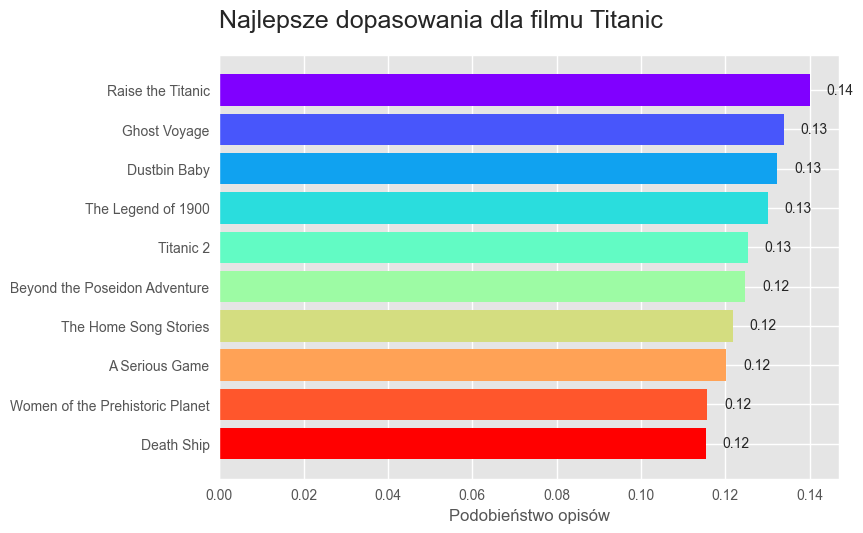

In [216]:
movie_title = 'Titanic'
top_matches = find_similar_to(title=movie_title)
create_chart_for_matches(matches=top_matches, title=movie_title, savetofile=False)

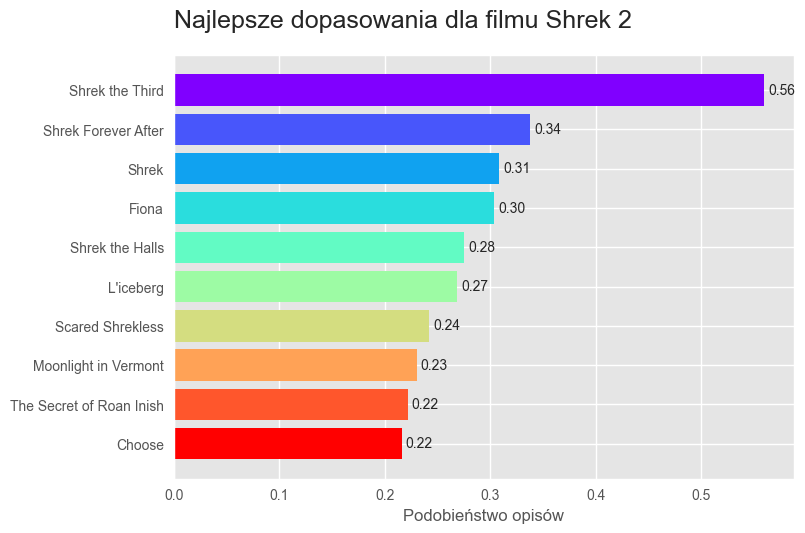

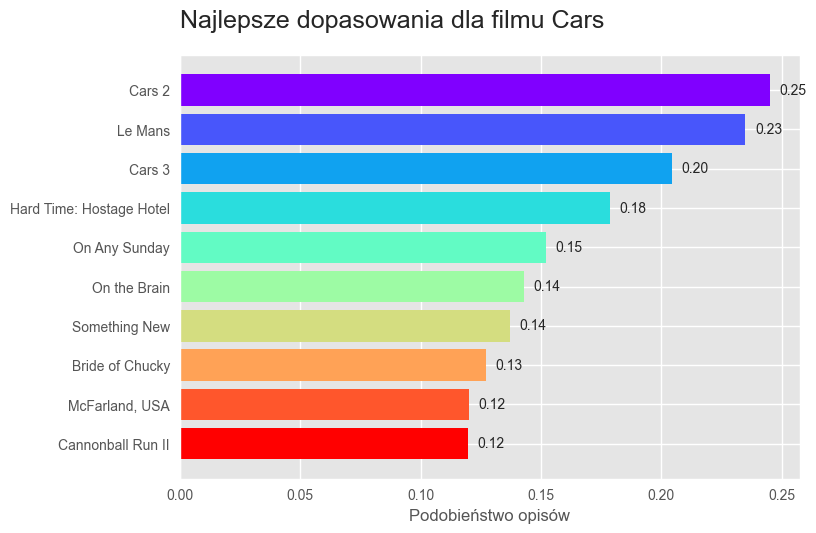

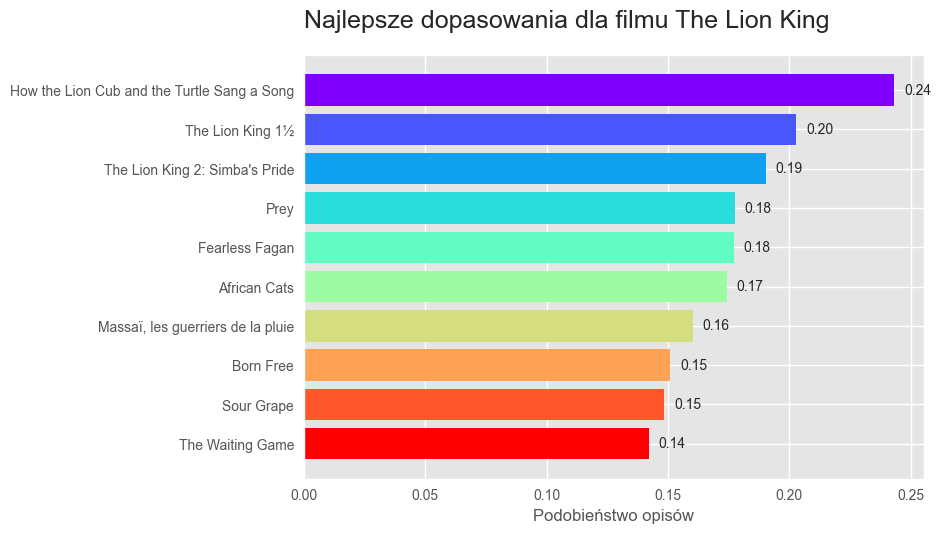

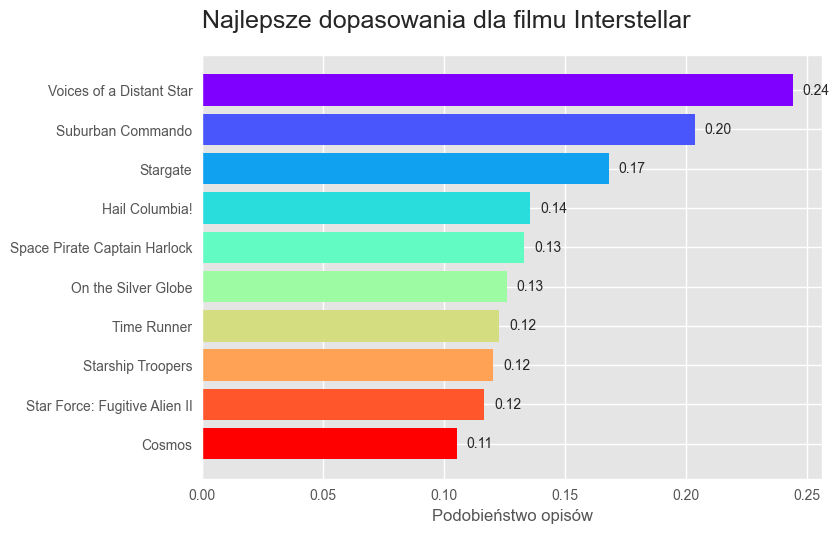

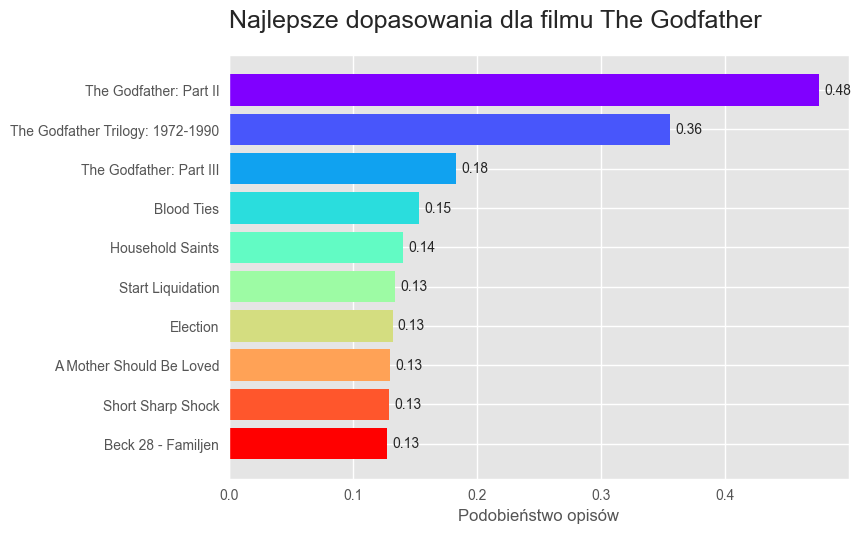

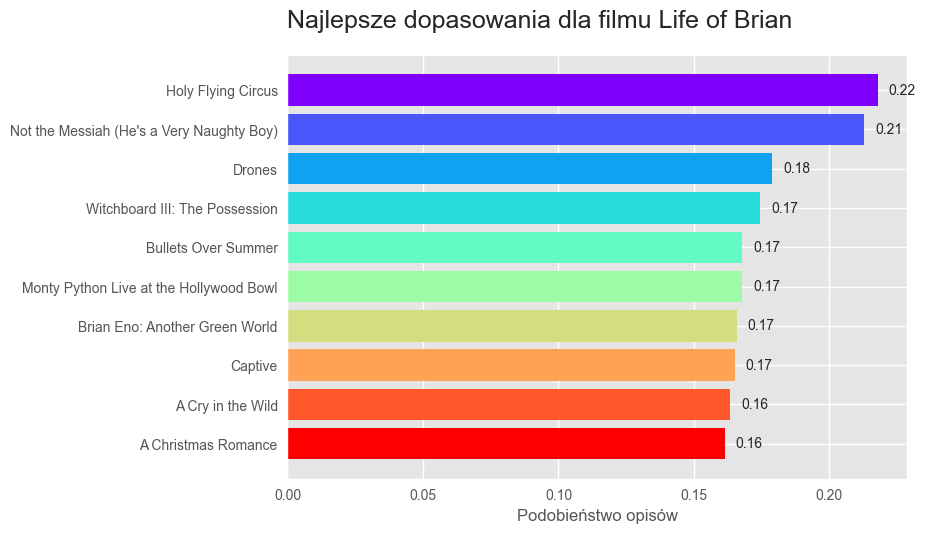

In [217]:
titles = [
    'Shrek 2',
    'Cars',
    'The Lion King',
    'Interstellar',
    'The Godfather',
    'Life of Brian'
]
for title in titles:
    top_matches = find_similar_to(title=title)
    create_chart_for_matches(matches=top_matches, title=title, savetofile=True)